# Macroeconomía I

## Programación Dinámica Estocástica e Iteración de la Función Valor

## (El Modelo Neoclásico de Crecimiento Estocástico)

Mauricio M. Tejada

ILADES - Universidad Alberto Hurtado

### El Problema de Opmización 

El problema de optimización del planificador central es el siguiente:
\begin{eqnarray*}
\max U_{0} & = & E_0 \sum_{t=0}^{\infty}\beta^{t}\ln c_{t}\\
s.a &  & c_{t}+i_{t}=A_t k_{t}^{\alpha}\\
 &  & k_{t+1}=i_{t}\\
 &  & k_{0},A_0 \ dados.
\end{eqnarray*}

Alternativamente:
\begin{eqnarray*}
\max U_{0} & = & E_0 \sum_{t=0}^{\infty}\beta^{t}\ln c_{t}\\
s.a &  & c_{t}+k_{t+1}=A_t k_{t}^{\alpha}\\
 &  & k_{0},A_0 \ dados.
\end{eqnarray*}

La productividad es una cadena de Markov con el espacio de estados dado por: $S = \{A_L,A_H\}$ y la matriz de transición caraterizada por: $\Pr[A_L|A_L] = p$ y $\Pr[A_H|A_H] = q$.

La ecuación de Bellman es:
$$
v(k_{t},A_{t})=\max_{k_{t+1}}\left\{ \log\left(A_tk_{t}^{\alpha}-k_{t+1}\right)+\beta E_t[v(k_{t+1},A_{t+1})]\right\} 
$$

Escribiendo explícitamente la expectativa tenemos:

$$
v(k_{t},A_L)=\max_{k_{t+1}}\left\{ \log\left(A_L k_{t}^{\alpha}-k_{t+1}\right)+\beta [p v(k_{t+1},A_L) + (1-p)v(k_{t+1},A_H) ]\right\} 
$$

$$
v(k_{t},A_H)=\max_{k_{t+1}}\left\{ \log\left(A_H k_{t}^{\alpha}-k_{t+1}\right)+\beta [(1-q) v(k_{t+1},A_L) + qv(k_{t+1},A_H) ]\right\} 
$$

La solución del problema funcional está dada por la función valor y la función de política:

$$
v(k_{k},z_t)\,\,y\,\,k_{t+1}=g(k_{t},z_t)
$$

### Implementación Solución Numérica

Algoritmo:

1. Definir un grid de puntos $k$ (discretización) y realizar una conjetura para $v(k,A)$ en cada posible punto del grid y para cada valor de $A$. 
2. Usando la conjetura evaluar el operador $Tv$ para cada punto en el grid (esto implica resolver el $\max$).
3. Evaluar si $v=Tv$ (usando algún grado de tolerancia), en tal caso terminar el proceso. Caso contrario volver al punto 2 usando la función valor resultante.

En términos de la ecuación de Bellman, la iteración sería:
$$
v_{j+1}(k,A)=\max_{k'}\left\{ \ln\left(Ak^{\alpha}-k'\right)+\beta E[v_{j}(k',A')]\right\} 
$$

Partir con algún $v_{0}(k,A)$. 

In [1]:
# Discretizamos la variable de estado. Definimos primero el número de puntos en el grid de k
n = 500

500

Parametros del modelo:

In [2]:
AL = 0.8   # tecnologia en estado bajo
AH = 1.2   # tecnologia en estado alto
Avec  = [AL, AH]
p  = 0.65  # \Pr[A_L|A_L] = p
q  = 0.65  # \Pr[A_H|A_H] = q
α = 0.36   # participacion del capital   
β = 0.9;   # factor de descuento  

crit = 1e-6;   # valor critico de convergencia

Encontramos la distribución invariante de $A$ para calcular el estado estacionario del modelo:

In [3]:
# Distribución invariante de A. Inicializamos la distribución
π0 = [0.5, 0.5]'
P = [p 1-p; 1-q q]

dif_pi = 1
π1 = similar(π0)

while dif_pi > crit
    
    global π0, π1, dif_pi
    
    π1 = π0*P
    dif_pi = abs(maximum(π1 - π0))
    π0 = copy(π1)
end

println("Distribución invariante: $π0")

Distribución invariante: [0.5 0.5]


Definimos el grid de puntos de $k$ como $k_1,...,k_n \in [0.6k^*,1.4k^*]$

In [4]:
# Calcular kss y definir kgrid  
kss   = ((π0[1,1]*AL + π0[1,2]*AH)*α*β)^(1/(1-α))                       # capital en EE    
kgrid = kss * collect(range(0.6,stop=1.4,length=n));  # n x 1  

println("k de estado estacionario: $kss")

k de estado estacionario: 0.17188048815558038


Note que mientras más puntos tengamos en el grid, más precisión tendremos.

El siguiente paso es iterar la función valor partiendo de la siguiente conjetura:
$$
v_{0}(k,A)=\left[\begin{array}{cc}
0 & 0\\
\vdots & \vdots \\
0 & 0
\end{array}\right]
$$

In [5]:
# Definir valores inciales

val0 = zeros(n,2);  # Conjetura Inicial  

In [6]:
# Paquetes necesarios
using Optim
using Interpolations

Usamos interpolación lineal para evaluar la función entre los puntos definidos en el grid del capital y para cada valor de $A$, por ejemplo:

In [7]:
v_interpolate_L = LinearInterpolation(kgrid, val0[:,1], extrapolation_bc = Line())
v_interpolate_H = LinearInterpolation(kgrid, val0[:,2], extrapolation_bc = Line());

Resolvemos usando el método de iteración de la función valor:

In [9]:
diff_val = 1
val1  = zeros(n,2)  # Vector para guardar la función valor
kdeci = zeros(n,2)  # Vector para guardar la función de política 

while diff_val > crit
    
global val0, val1, kdeci, diff_val

for j = 1:2
    A = Avec[j]
    PT = P[j,:]

    v_interpolate_L = LinearInterpolation(kgrid, val0[:,1], extrapolation_bc = Line())
    v_interpolate_H = LinearInterpolation(kgrid, val0[:,2], extrapolation_bc = Line()) 
    Tv(k,kf) = log(A*k^α-kf) + β*(PT[1]*v_interpolate_L(kf) + PT[2]*v_interpolate_H(kf))

    for i in 1:n
        res = optimize(x -> -Tv(kgrid[i],x), 1e-10, A*kgrid[i]^α)
        kdeci[i,j] = res.minimizer
        val1[i,j] = -res.minimum
    end

end

diff_val = abs(maximum(val1-val0))      
val0 = copy(val1) 
end

println("Convergencia = $diff_val");

Convergencia = 8.156625312949473e-7


### Gráficos

In [10]:
using LaTeXStrings
using Plots

Función de política:

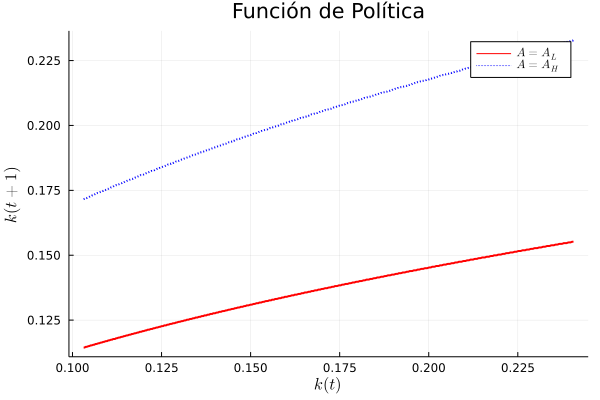

In [11]:
plot(kgrid, kdeci, title = "Función de Política", 
     xlabel = L"k(t)", ylabel = L"k(t+1)", label=[L"A=A_L" L"A=A_H"], 
     linewidth = 2, grid = true, line=[:solid :dot], color=[:red :blue])

Función valor:

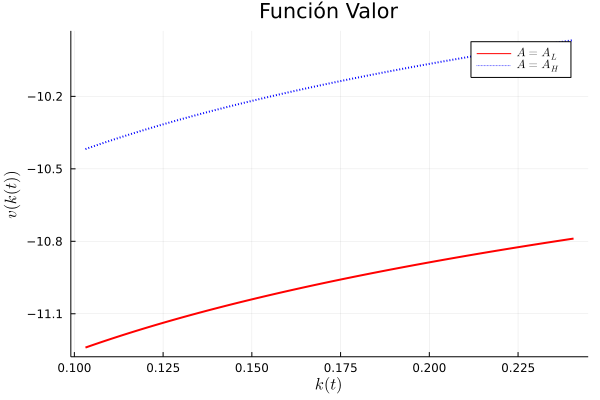

In [12]:
plot(kgrid, val1, title = "Función Valor", 
     xlabel = L"k(t)", ylabel = L"v(k(t))", label=[L"A=A_L" L"A=A_H"], 
     linewidth = 2, grid = true, line=[:solid :dot], color=[:red :blue])